In [2]:
#hscnn+  (rf+pca)
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
import gc

# Paths
DATASET_PATH = "/kaggle/input/hsi-skincancer-main/train/hscnn_plus"

# Only classes 3, 4, 5
selected_classes = ['class_3', 'class_4', 'class_5']

# Load data
X, y = [], []
label_map = {cls: i for i, cls in enumerate(selected_classes)}

print("Loading selected classes...")
for class_name in selected_classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    label = label_map[class_name]
    for file_name in tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
        file_path = os.path.join(class_path, file_name)
        arr = np.load(file_path)  # shape: (31, 256, 256)
        arr = arr[:, :32, :32]    # Crop to reduce memory if needed
        X.append(arr)
        y.append(label)

X = np.array(X)  # shape: (N, 31, 32, 32)
y = np.array(y)
print(f"Total samples loaded: {len(X)}")

# Flatten spatial dims and reshape
X = X.reshape(len(X), -1)  # shape: (N, 31*32*32)

# Apply PCA
print("Applying PCA...")
pca = PCA(n_components=30, random_state=42)
X_pca = pca.fit_transform(X)

# Split
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, stratify=y, random_state=42)

# Train RF
print("Training Random Forest...")
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Eval
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Macro-F1: {f1:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Cleanup
del X, X_pca, X_train, X_test, y_train, y_test
gc.collect()


Loading selected classes...


Loading class_5: 100%|██████████| 462/462 [00:19<00:00, 23.70it/s]


Total samples loaded: 1386
Applying PCA...
Splitting data...
Training Random Forest...
Accuracy: 0.6082
Macro-F1: 0.6063
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.63      0.61       138
           1       0.56      0.50      0.53       139
           2       0.66      0.69      0.68       139

    accuracy                           0.61       416
   macro avg       0.61      0.61      0.61       416
weighted avg       0.61      0.61      0.61       416



325

In [6]:
#mst++ rf+pca
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import joblib

# Define paths
base_dir = "/kaggle/input/hsi-skincancer-main/train/mst_plus_plus"
selected_classes = ['class_3', 'class_4', 'class_5']
label_map = {cls: idx for idx, cls in enumerate(selected_classes)}

# Load the data
X = []
y = []

print("Loading data...")
for cls_name in selected_classes:
    cls_path = os.path.join(base_dir, cls_name)
    label = label_map[cls_name]
    
    for fname in tqdm(os.listdir(cls_path), desc=f"Loading {cls_name}"):
        if fname.endswith(".npy"):
            img = np.load(os.path.join(cls_path, fname))
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)
print("Total samples loaded:", len(X))

# Flatten hyperspectral images
X = X.reshape(X.shape[0], -1)

# Apply PCA
print("Applying PCA...")
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X)

# Train/test split
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42, stratify=y)

# Train Random Forest
print("Training Random Forest...")
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
print("Evaluating...")
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro-F1: {macro_f1:.4f}")
print("Classification Report:")
print(report)

# Save model and PCA
joblib.dump(clf, "rf_mst_plus_plus.pkl")
joblib.dump(pca, "pca_mst_plus_plus.pkl")


Loading data...


Loading class_5: 100%|██████████| 462/462 [00:02<00:00, 213.52it/s]


Total samples loaded: 1386
Applying PCA...
Splitting data...
Training Random Forest...
Evaluating...
Accuracy: 0.7188
Macro-F1: 0.7154
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       138
           1       0.67      0.58      0.62       139
           2       0.76      0.81      0.78       139

    accuracy                           0.72       416
   macro avg       0.72      0.72      0.72       416
weighted avg       0.72      0.72      0.72       416



['pca_mst_plus_plus.pkl']

In [4]:
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm

# Define paths
base_path = '/kaggle/input/hsi-skincancer-main/train/hrnet'
selected_classes = ['class_3', 'class_4', 'class_5']

X, y = [], []

# Load data
label_map = {cls: idx for idx, cls in enumerate(selected_classes)}
print("Loading data from HRNet...")
for cls in selected_classes:
    class_path = os.path.join(base_path, cls)
    for file in tqdm(os.listdir(class_path), desc=f"Loading {cls}"):
        if file.endswith('.npy'):
            img = np.load(os.path.join(class_path, file))
            X.append(img.flatten())
            y.append(label_map[cls])

X = np.array(X)
y = np.array(y)
print(f"Total samples loaded: {len(X)}")

# Apply PCA
print("Applying PCA...")
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X)

# Split data
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, stratify=y, random_state=42)

# Train Random Forest
print("Training Random Forest...")
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
print("Evaluating...")
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"Macro-F1: {f1:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))




Loading data from HRNet...


Loading class_5: 100%|██████████| 462/462 [00:02<00:00, 175.89it/s]


Total samples loaded: 1386
Applying PCA...
Splitting data...
Training Random Forest...
Evaluating...
Accuracy: 0.7236
Macro-F1: 0.7213
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.71      0.74       138
           1       0.67      0.62      0.64       139
           2       0.74      0.84      0.79       139

    accuracy                           0.72       416
   macro avg       0.72      0.72      0.72       416
weighted avg       0.72      0.72      0.72       416



In [5]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from joblib import dump
from tqdm import tqdm

# --- Settings ---
base_dir = '/kaggle/input/hsi-skincancer-main/train/awan'
selected_classes = [3, 4, 5]
class_labels = {3: 0, 4: 1, 5: 2}
n_components = 15  # number of PCA components

# --- Load Data ---
X, y = [], []

print("Loading data...")
for cls in selected_classes:
    cls_dir = os.path.join(base_dir, f'class_{cls}')
    if not os.path.exists(cls_dir):
        raise FileNotFoundError(f"Missing folder: {cls_dir}")
    for fname in tqdm(os.listdir(cls_dir), desc=f"Loading class_{cls}"):
        path = os.path.join(cls_dir, fname)
        arr = np.load(path)  # shape: (31, 256, 256)
        X.append(arr)
        y.append(class_labels[cls])

X = np.array(X)
y = np.array(y)
print(f"Total samples loaded: {len(X)}")

# --- Preprocess: Flatten and PCA ---
X_flat = X.reshape(X.shape[0], -1)
print("Applying PCA...")
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_flat)

# --- Split ---
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42, stratify=y)

# --- Train ---
print("Training Random Forest...")
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# --- Evaluate ---
print("Evaluating...")
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"Macro-F1: {f1:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))



Loading data...


Loading class_5: 100%|██████████| 462/462 [00:19<00:00, 23.94it/s]


Total samples loaded: 1386
Applying PCA...
Splitting data...
Training Random Forest...
Evaluating...
Accuracy: 0.5769
Macro-F1: 0.5707
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       138
           1       0.48      0.39      0.43       139
           2       0.67      0.72      0.69       139

    accuracy                           0.58       416
   macro avg       0.57      0.58      0.57       416
weighted avg       0.57      0.58      0.57       416



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Project to 2D for visualization
pca_2d = PCA(n_components=2)
X_vis = pca_2d.fit_transform(X_flat)

# Plot
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(X_vis[y == label, 0], X_vis[y == label, 1], label=f'Class {label}', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Projection of Hyperspectral Data')
plt.legend()
plt.grid(True)
plt.show()



Original shape: (31, 256, 256)
Transposed shape: (256, 256, 31)


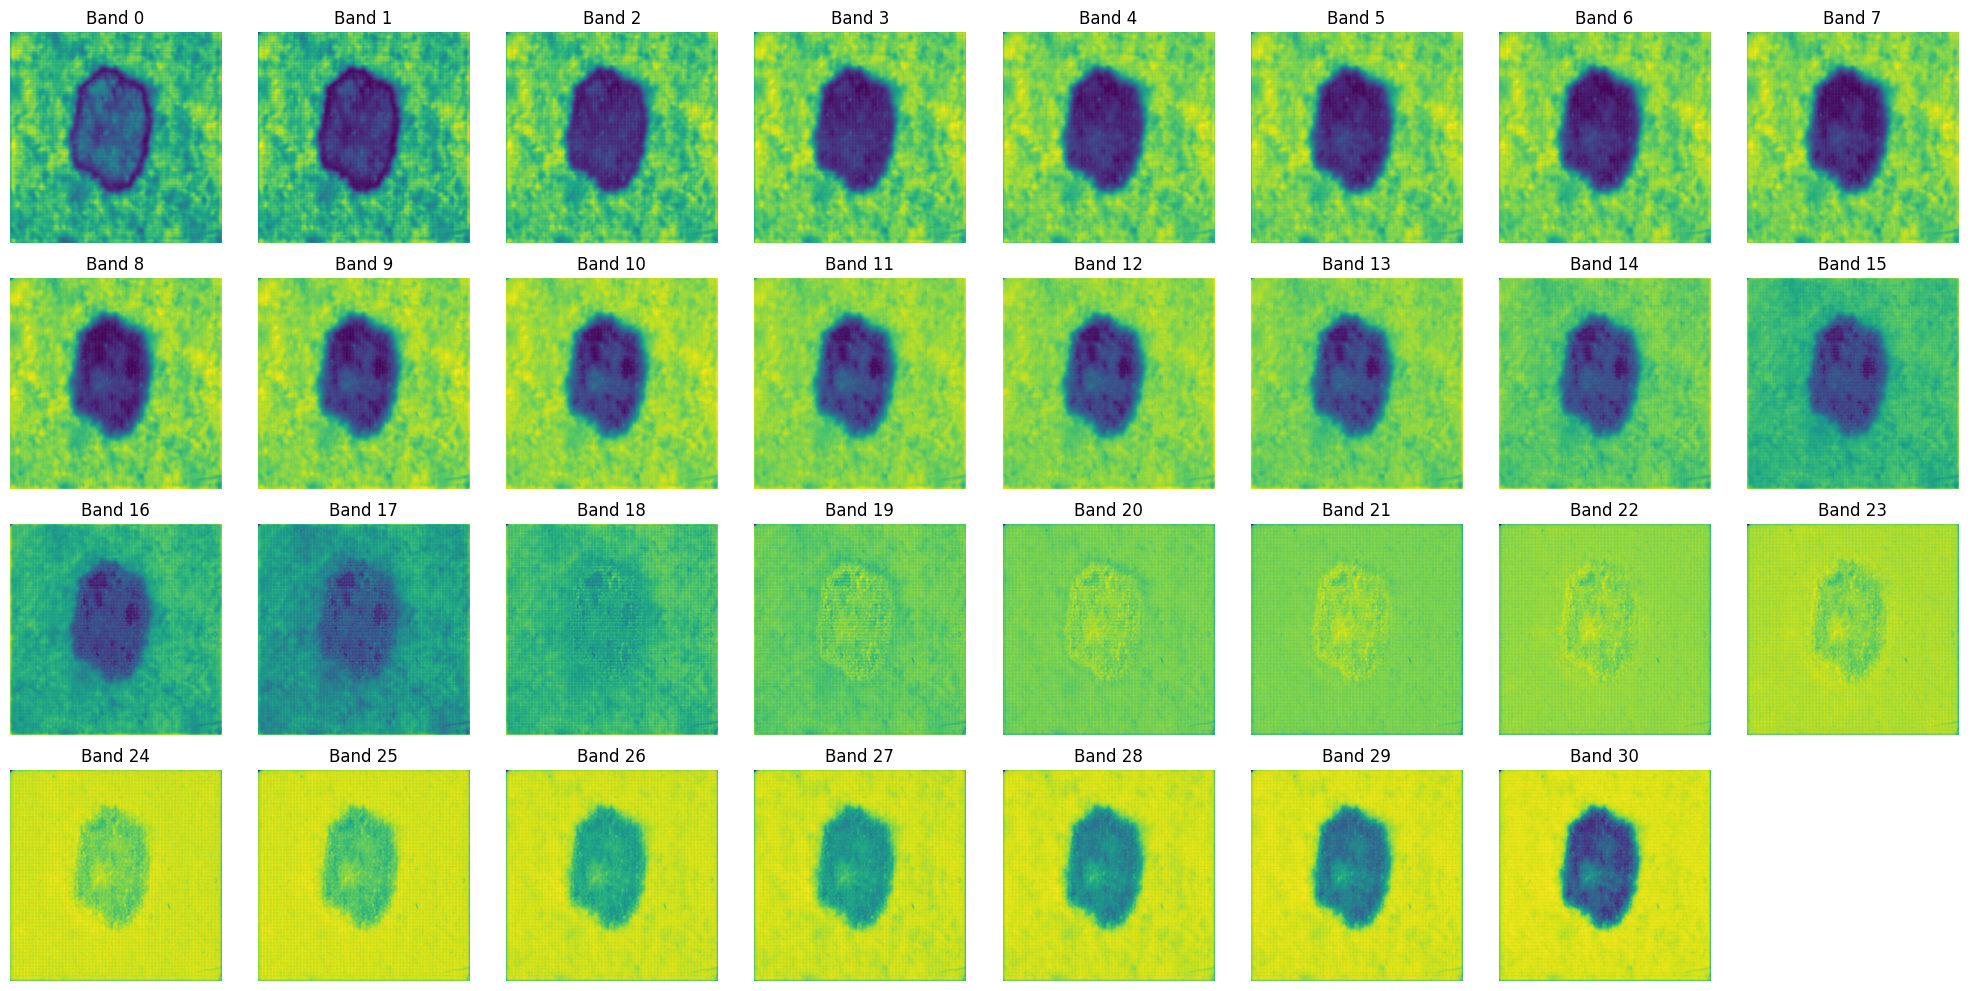

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Load .npy file
hsi = np.load('/kaggle/input/hsi-skincancer-main/train/mst_plus_plus/class_4/image_1025.npy')  # Replace with your actual file path
print("Original shape:", hsi.shape)

# Transpose to (H, W, Bands)
hsi = np.transpose(hsi, (1, 2, 0))  # From (31, 256, 256) to (256, 256, 31)
print("Transposed shape:", hsi.shape)

# Plot all bands in a grid
num_bands = hsi.shape[2]
cols = 8
rows = math.ceil(num_bands / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    if i < num_bands:
        ax.imshow(hsi[:, :, i], cmap='viridis', aspect='equal')
        ax.set_title(f'Band {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


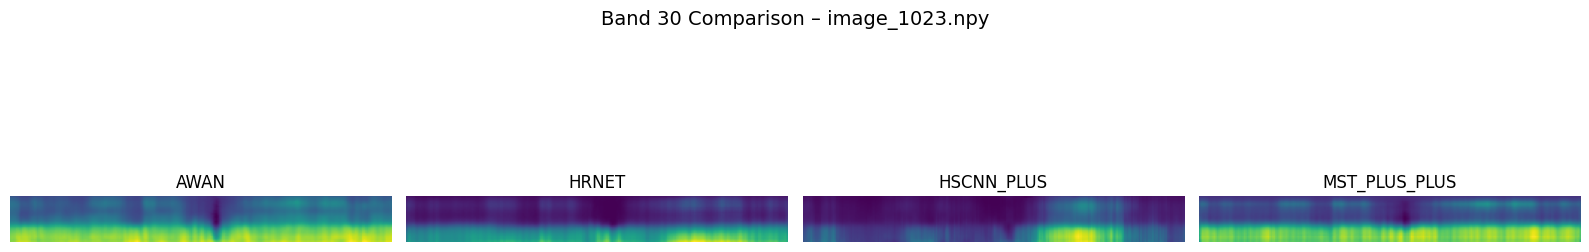

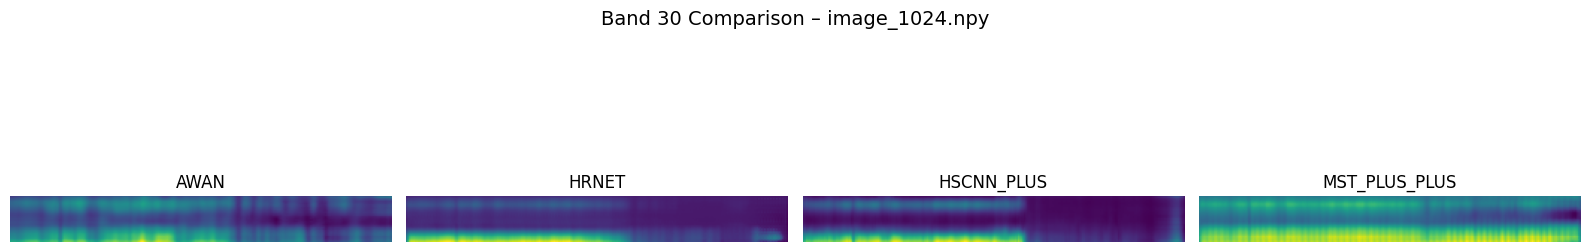

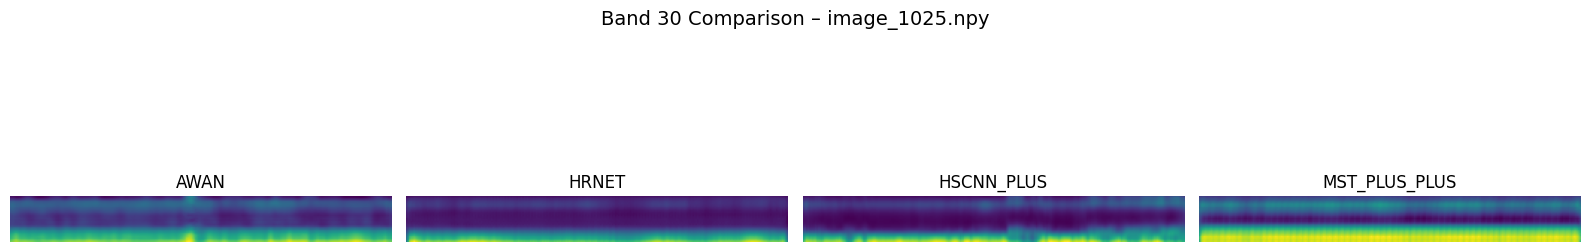

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define base directory and model names
base_path = '/kaggle/input/hsi-skincancer-main/train'
models = ['awan', 'hrnet', 'hscnn_plus', 'mst_plus_plus']
image_names = ['image_1023.npy', 'image_1024.npy', 'image_1025.npy']
target_class = 'class_4'
band_index = 30  # 31st band (indexing from 0)

for img_name in image_names:
    fig, axes = plt.subplots(1, len(models), figsize=(16, 4))
    fig.suptitle(f"Band {band_index} Comparison – {img_name}", fontsize=14)

    for i, model in enumerate(models):
        file_path = os.path.join(base_path, model, target_class, img_name)
        if not os.path.exists(file_path):
            print(f"Missing: {file_path}")
            axes[i].set_title(f"{model.upper()}\n(Missing)")
            axes[i].axis('off')
            continue

        hsi = np.load(file_path)

        # Transpose if shape is (Bands, H, W)
        if hsi.shape[0] < 10:
            hsi = np.transpose(hsi, (1, 2, 0))

        band_img = hsi[:, :, band_index]
        band_img = (band_img - band_img.min()) / (band_img.max() - band_img.min() + 1e-6)  # Normalize

        axes[i].imshow(band_img, cmap='viridis')
        axes[i].set_title(model.upper())
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
